# Setup

In [50]:
import os
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import math
from matplotlib import pyplot as plt
from IPython.display import Markdown as md

In [51]:
TRAIN_PATH = os.environ['TRAINING_DATA_LOCATION']
TEST_PATH = os.environ['TEST_DATA_LOCATION']

# Load data

In [52]:
train_df = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'), parse_dates=['date'],index_col='id')
train_df

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [53]:
test_df = pd.read_csv(os.path.join(TEST_PATH, 'test.csv'), parse_dates=['date'], index_col='id')
test_df

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


For now we are only interested in the bare-bone data about sales, ignoring additional CSV files.

# Check for missing values

In [54]:
assert train_df.isna().sum().sum() == 0

There are no missing values in the train dataframe.

In [55]:
assert test_df.isna().sum().sum() == 0

Thare are no missing values in the test dataframe.

# How many different stores do we have?

In [56]:
md(f'We have `{train_df.store_nbr.nunique()}` different stores.')

We have `54` different stores.

In [57]:
# Check if the stores from test set are in the training set
train_stores = set(train_df.store_nbr.unique())
test_stores = set(test_df.store_nbr.unique())
assert test_stores <= train_stores

All the stores from the test set are also in the train set.

# How many different categories of products do we have?

In [58]:
md(f'We have `{train_df.family.nunique()}` different product families.')

We have `33` different product families.

# Average sales for different stores

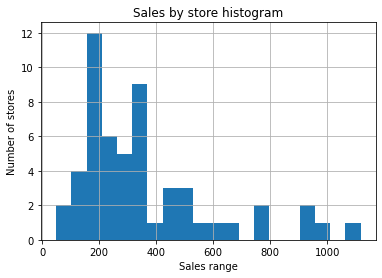

In [59]:
train_df.groupby('store_nbr').agg({'sales': 'mean'}).hist(bins=20)
# set plot x label
plt.xlabel('Sales range')
# set plot y label
plt.ylabel('Number of stores')
# set plot title
_ = plt.title('Sales by store histogram')

# Average sales for different product families

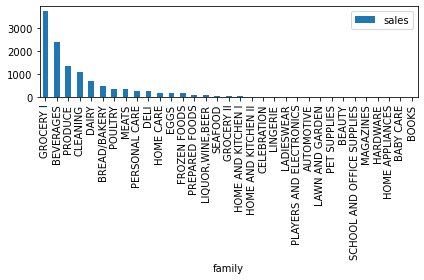

In [60]:
train_df.groupby('family').agg({'sales': 'mean'}).sort_values('sales', ascending=False).plot.bar()
plt.tight_layout()

The most surprising thing is that the average sales for baby care products are so low.

# Let's see how much data do we have by date

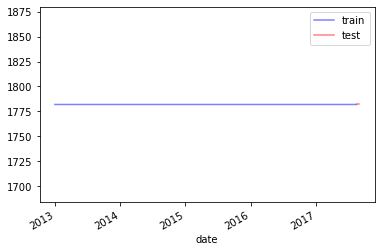

In [61]:
train_df.groupby('date').sales.count().plot(kind='line', label='train', color='blue', alpha=0.5)
test_df.groupby('date').store_nbr.count().plot(kind='line', label='test', color='red', alpha=0.5)
_ = plt.legend()

Seems that our data is evenly distributed by date.

# Look for trends in sales samples

In [62]:
# group by store and product family
grouped_df = train_df.groupby(['store_nbr', 'family'])

In [63]:
# salect random subset of grouping keys
sample_groups = random.sample(grouped_df.groups.keys(), 10)
sample_groups

[(28, 'HOME AND KITCHEN I'),
 (38, 'HOME CARE'),
 (31, 'HOME AND KITCHEN II'),
 (5, 'PRODUCE'),
 (43, 'PLAYERS AND ELECTRONICS'),
 (26, 'HOME CARE'),
 (38, 'SEAFOOD'),
 (26, 'BOOKS'),
 (40, 'EGGS'),
 (21, 'HOME AND KITCHEN I')]

In [64]:
def show_sales(grouped_df: pd.DataFrame) -> None:
    nrows = math.ceil(grouped_df.ngroups / 2)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(20, nrows * 2), sharex=True)
    for ax, grouping_key in zip(axes.ravel(), grouped_df.groups.keys()):
        data = grouped_df.get_group(grouping_key)

        trendline_coefficients = np.polyfit(x=data.date.map(pd.Timestamp.timestamp), y=data.sales, deg=1)
        a, b = trendline_coefficients
        trendline_polynomial = np.poly1d(trendline_coefficients)

        trend_indicator = {-1: 'downward', +1: 'upward', 0: 'constant'}[np.sign(a)]

        data.plot(x='date', y='sales', kind='line', ax=ax, label=grouping_key)
        ax.plot(data.date, trendline_polynomial(data.date.map(pd.Timestamp.timestamp)), 'r-', label=f'trendline ({trend_indicator})', alpha=0.5)

        ax.legend()

In [65]:
grouped_df.get_group((30, 'BABY CARE'))

,date,store_nbr,family,sales,onpromotion
id,,,,,
760,2013-01-01,30,BABY CARE,0.0,0
2542,2013-01-02,30,BABY CARE,0.0,0
4324,2013-01-03,30,BABY CARE,0.0,0
6106,2013-01-04,30,BABY CARE,0.0,0
7888,2013-01-05,30,BABY CARE,0.0,0
...,...,...,...,...,...
2992738,2017-08-11,30,BABY CARE,0.0,0
2994520,2017-08-12,30,BABY CARE,0.0,0
2996302,2017-08-13,30,BABY CARE,3.0,0


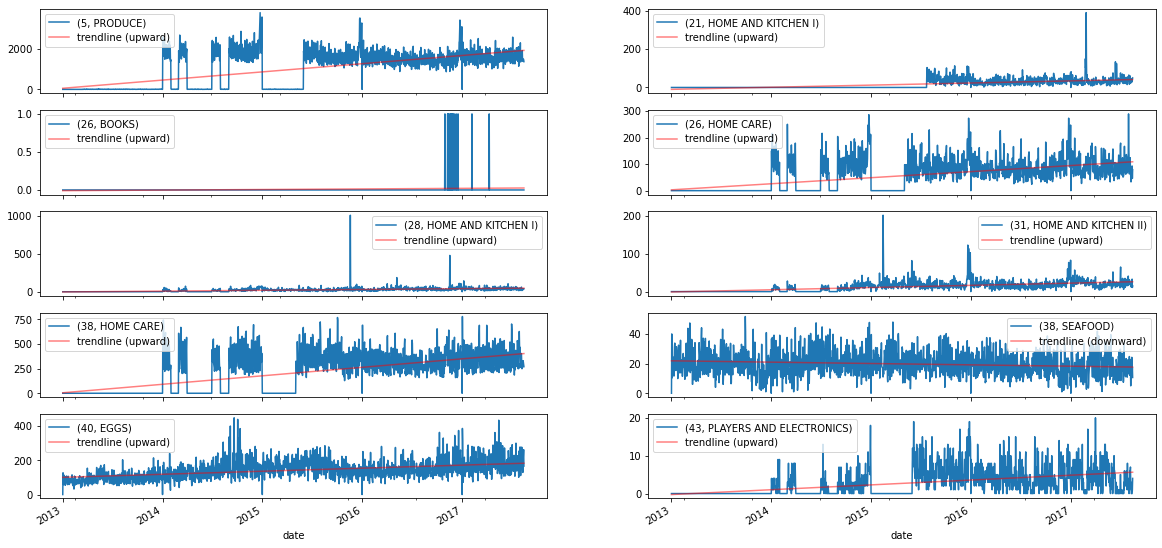

In [66]:
idx_for_sample_groups = np.concatenate([grouped_df.indices[sample_group] for sample_group in sample_groups])
sample_grouped_df = train_df.iloc[idx_for_sample_groups].groupby(['store_nbr', 'family'])
show_sales(sample_grouped_df)

We can observe a slight upward trend in sales of most product families.
Nobody seems to be buying books.

A more worrying insight is that there are some periods where the shops are selling zero items.

We should investigate if this is something across multiple stores or across categories.

# Investigate ladiesware sales across shops

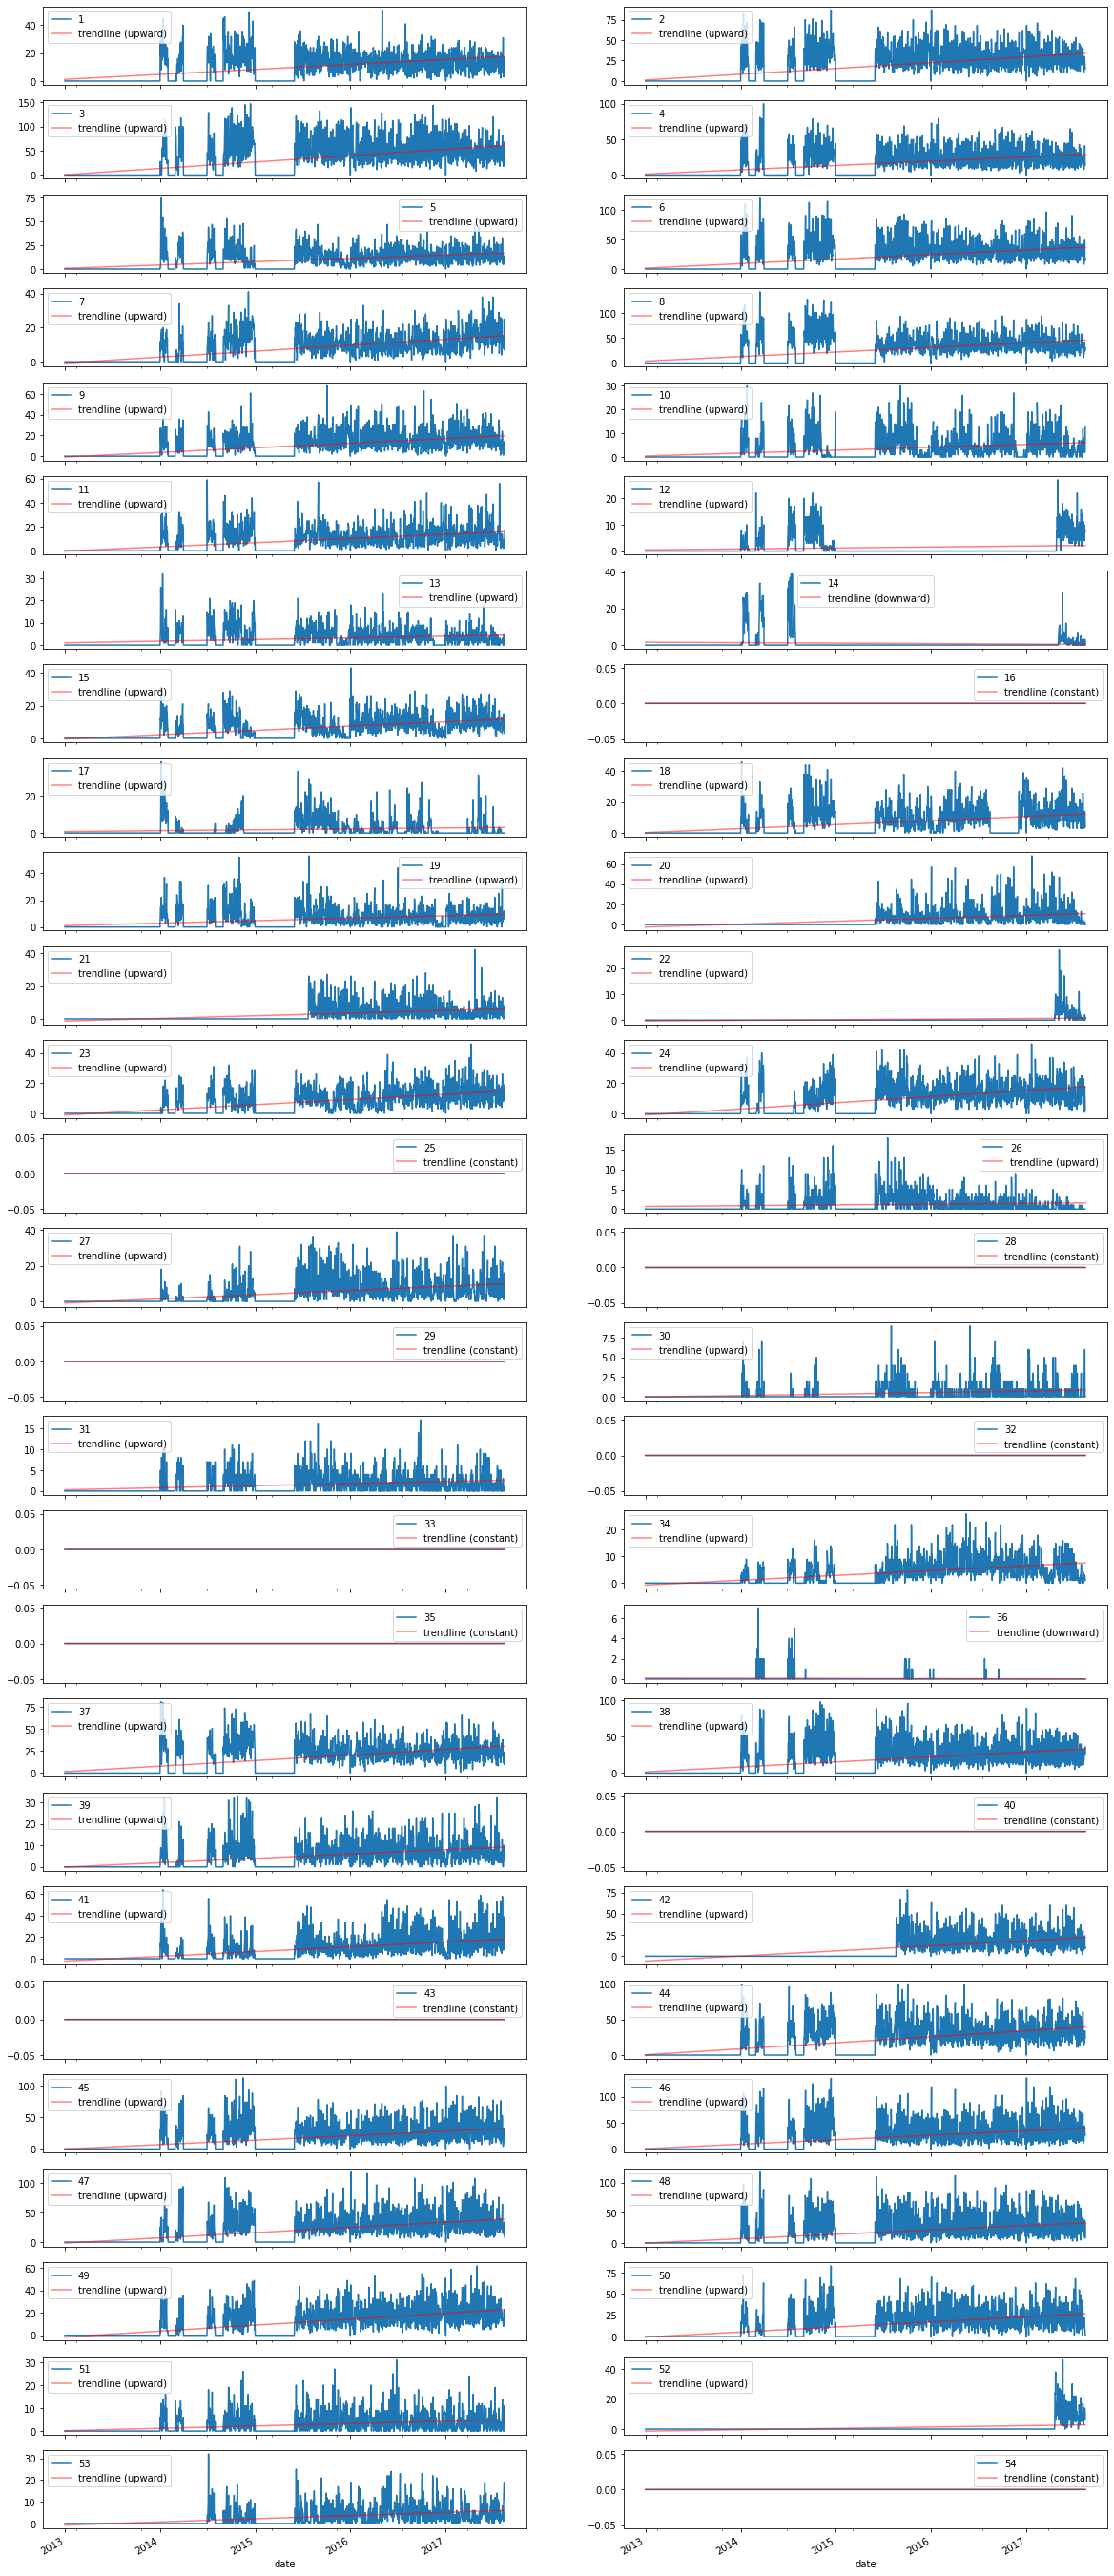

In [67]:
ladieswear = train_df[train_df.family == 'LADIESWEAR'].groupby('store_nbr')
show_sales(ladieswear)

Let's try to zoom in around the first half of 2015 and see what neighbours the brake in sales.

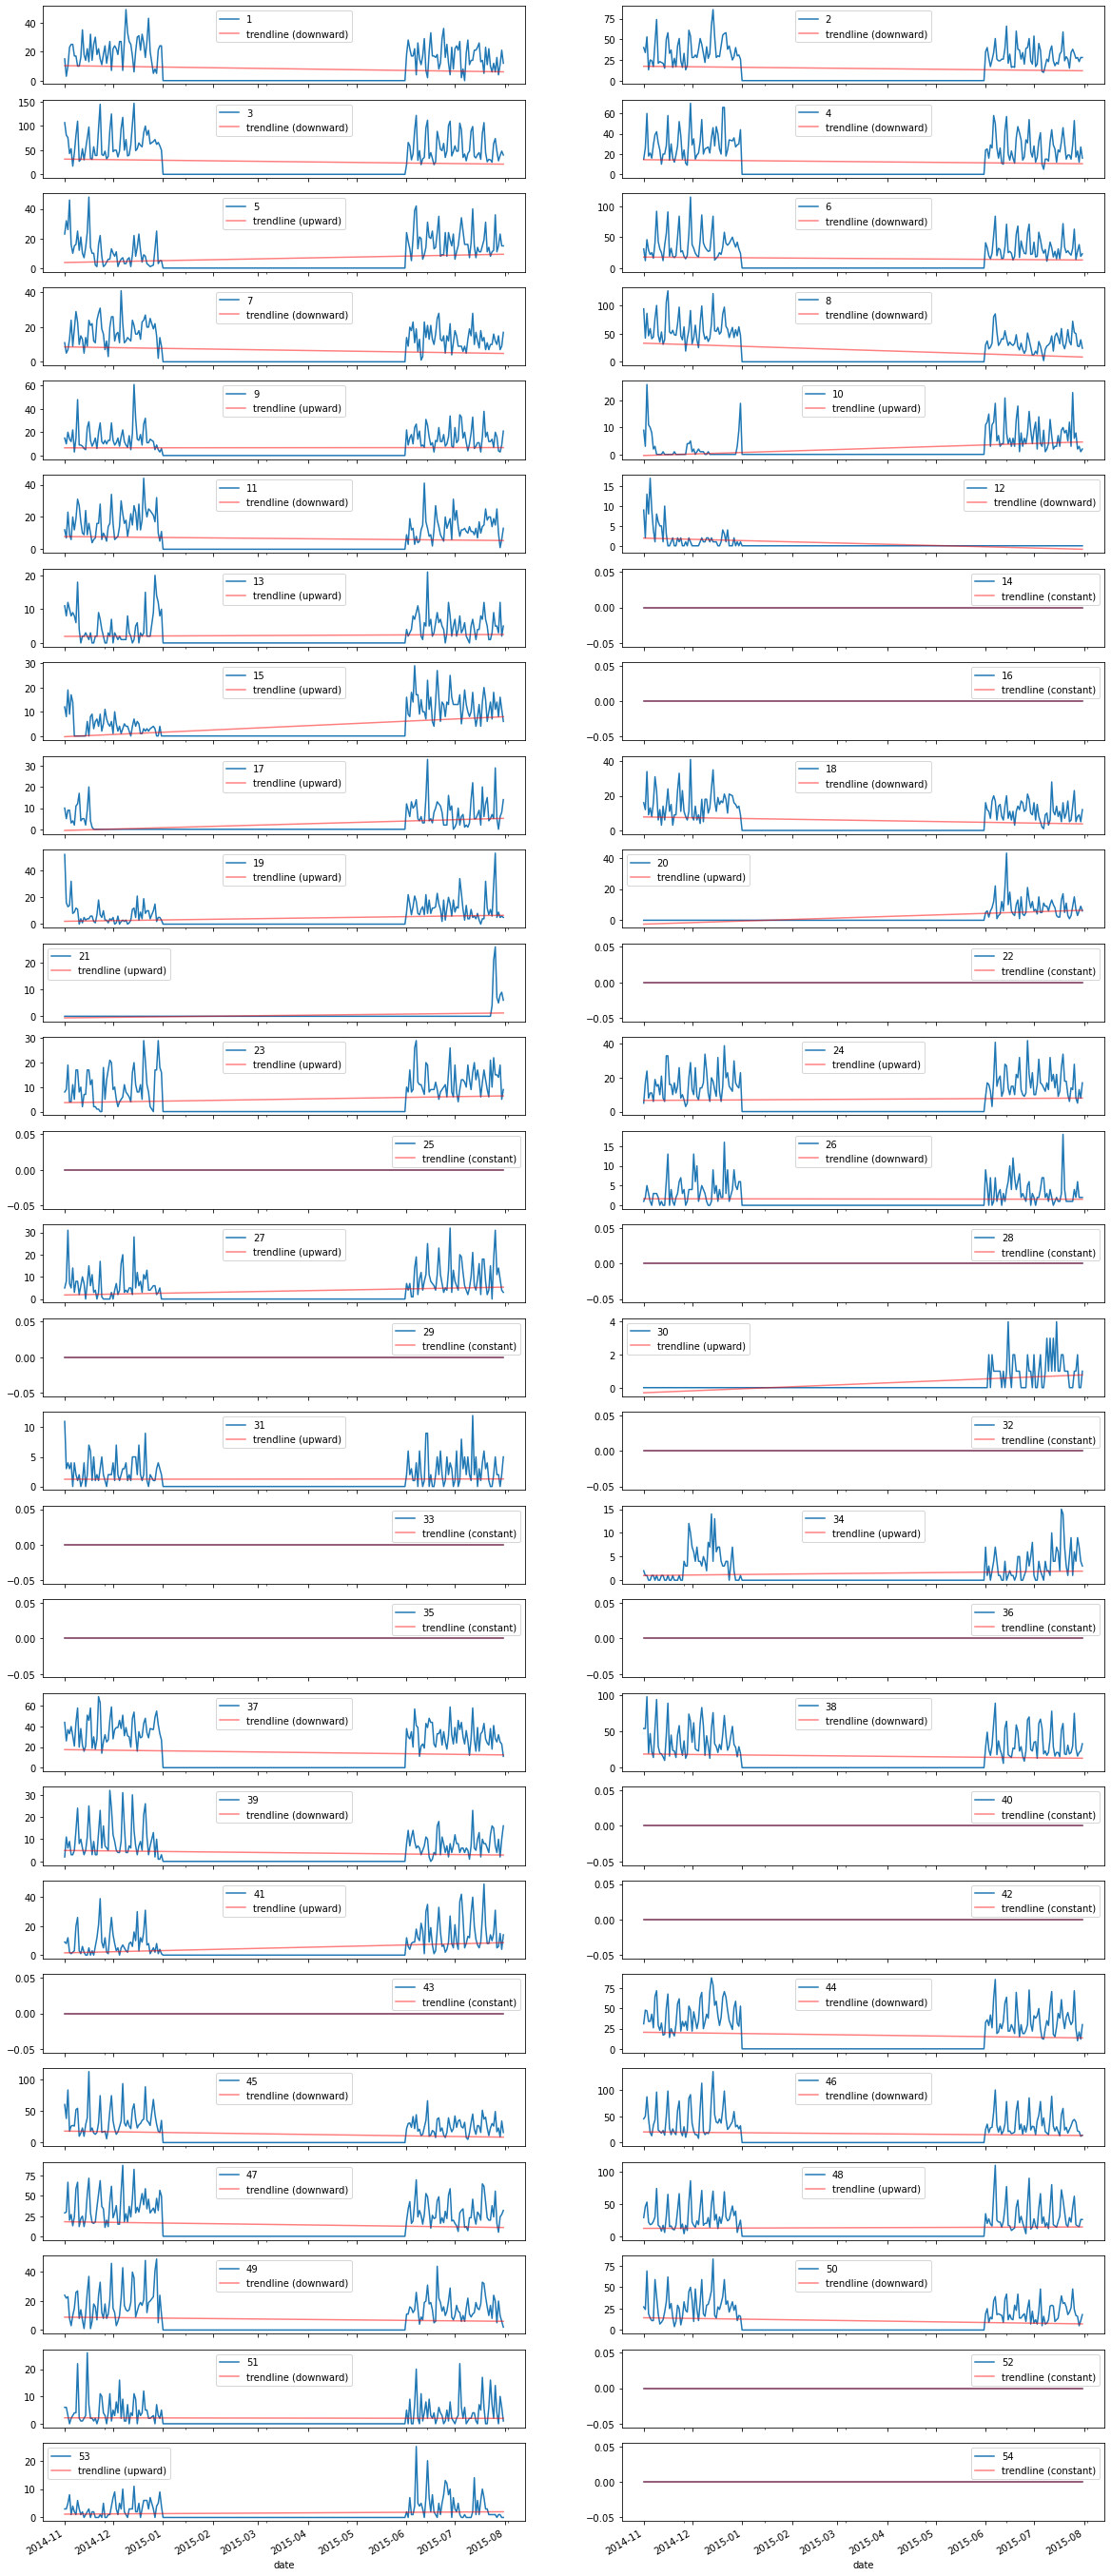

In [68]:
zoom_df = train_df[(train_df.date >= '2014-11-01') & (train_df.date <= '2015-07-31')]
zoom_ladieswear = zoom_df[zoom_df.family == 'LADIESWEAR'].groupby('store_nbr')
show_sales(zoom_ladieswear)

It doesn't seem like there is a soft decline in sales just before the sales drop to 0. My best guess is that all the shops stopped carrying this type of stock by an executive decision for half a year.

# Investigate sales trends across multiple categories of the same shop

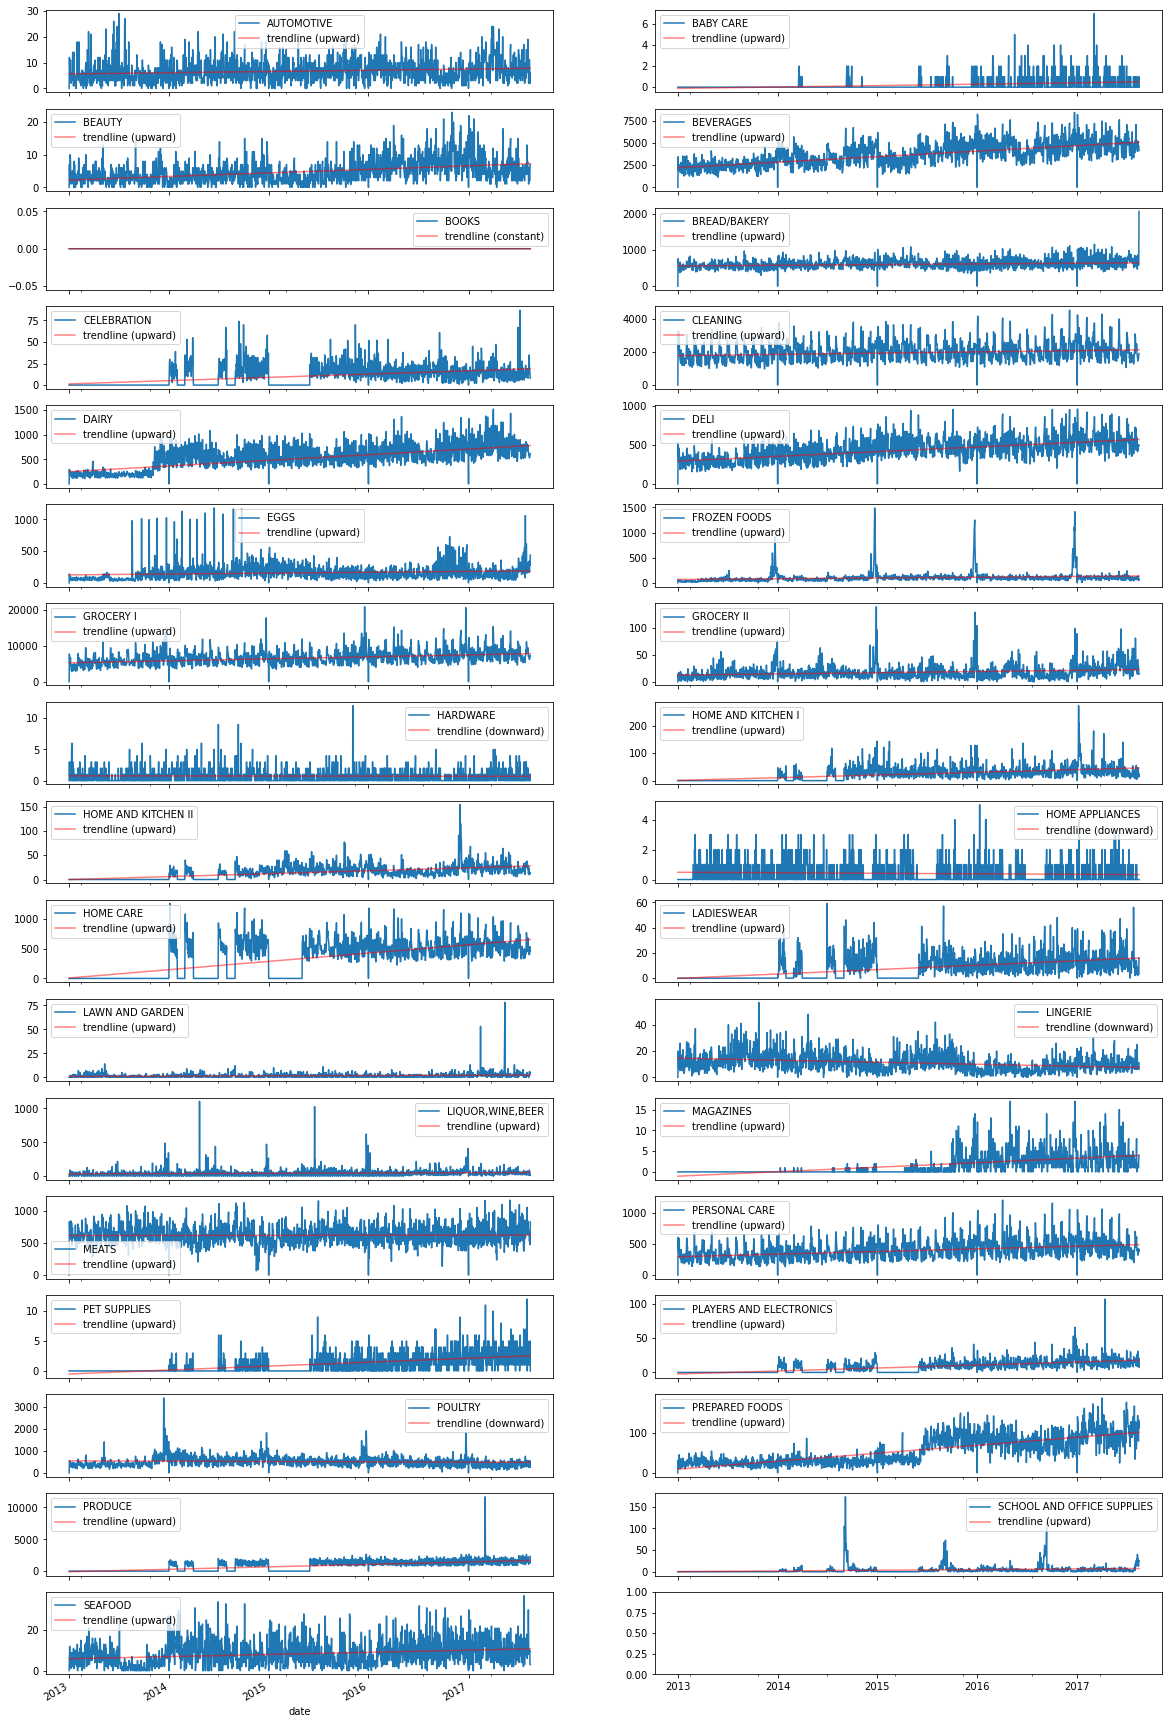

In [69]:
selected_store_nbr = 11
store_df = train_df[train_df.store_nbr == selected_store_nbr].groupby('family')
show_sales(store_df)

Seems that breaks touch different categories of the same shop. The brakes are not always limited to the same timeframe - there must have been separate independent decisions concerning different product families.

# Remove leading entries without sales

Not all sales record starts at the same time. We will want to exlude all leading entries without sales.

In [76]:
train_df['sales_cumsum'] = train_df.groupby(["store_nbr", "family"])["sales"].cumsum()
train_df

,date,store_nbr,family,sales,onpromotion,sales_cumsum
id,,,,,,
563,2013-01-01,25,BEAUTY,2.000,0,2.000000e+00
564,2013-01-01,25,BEVERAGES,810.000,0,8.100000e+02
566,2013-01-01,25,BREAD/BAKERY,180.589,0,1.805890e+02
568,2013-01-01,25,CLEANING,186.000,0,1.860000e+02
569,2013-01-01,25,DAIRY,143.000,0,1.430000e+02
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,8.148546e+05
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1.494759e+05
3000885,2017-08-15,9,PRODUCE,2419.729,148,1.632022e+06


In [77]:
# drop rows with cumulative sales being 0
train_df.drop(
    train_df[train_df['sales_cumsum'] == 0].index,
    inplace=True
)
train_df

,date,store_nbr,family,sales,onpromotion,sales_cumsum
id,,,,,,
563,2013-01-01,25,BEAUTY,2.000,0,2.000000e+00
564,2013-01-01,25,BEVERAGES,810.000,0,8.100000e+02
566,2013-01-01,25,BREAD/BAKERY,180.589,0,1.805890e+02
568,2013-01-01,25,CLEANING,186.000,0,1.860000e+02
569,2013-01-01,25,DAIRY,143.000,0,1.430000e+02
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,8.148546e+05
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1.494759e+05
3000885,2017-08-15,9,PRODUCE,2419.729,148,1.632022e+06


Check if we managed to remove the correct stuff.

In [79]:
assert len(train_df[train_df['sales_cumsum'] == 0]) == 0



First we check if the sample groups are still present.

In [80]:
grouped_df = train_df.groupby(['store_nbr', 'family'])
to_remove = []
for sample_group in sample_groups:
    try:
        assert sample_group in grouped_df.groups, sample_group
    except AssertionError:
        print(f"Group {sample_group} not found anymore. Removing it from sample groups.")
        to_remove.append(sample_group)
sample_groups = [sample_group for sample_group in sample_groups if sample_group not in to_remove]

Display the sample groups again.

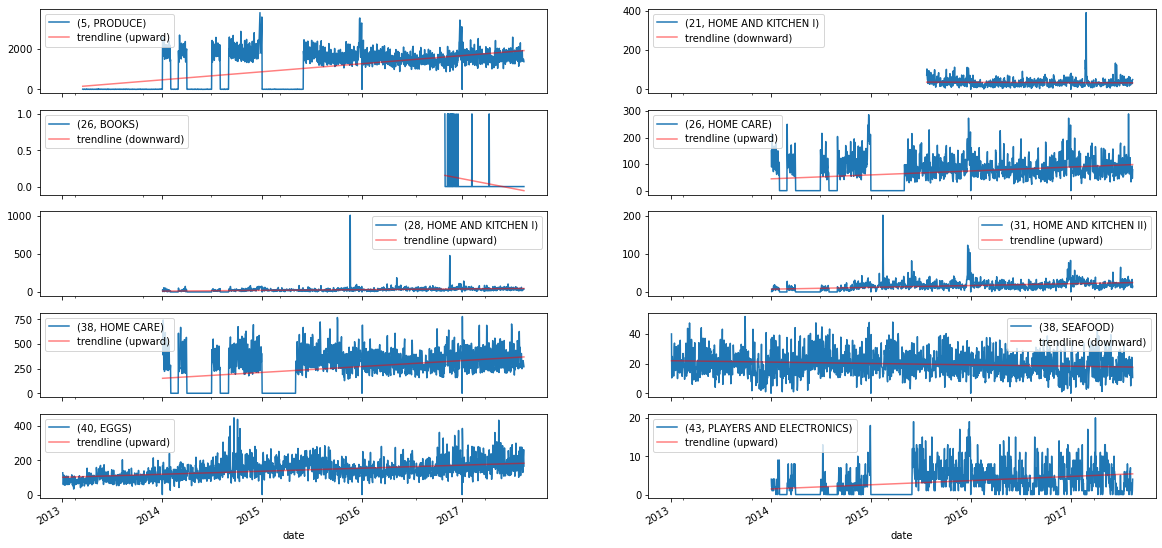

In [81]:
idx_for_sample_groups = np.concatenate([grouped_df.indices[sample_group] for sample_group in sample_groups])
sample_grouped_df = train_df.iloc[idx_for_sample_groups].groupby(['store_nbr', 'family'])
show_sales(sample_grouped_df)

We might want to exclude the breaks from sample generation - ignore time periods where sales of a particular familiy are zero (maybe for a set number of days).

# Check if we have small breaks in data

In [84]:
train_df['previous_date'] = grouped_df['date'].shift(1)
train_df

,date,store_nbr,family,sales,onpromotion,sales_cumsum,previous_date
id,,,,,,,
563,2013-01-01,25,BEAUTY,2.000,0,2.000000e+00,NaT
564,2013-01-01,25,BEVERAGES,810.000,0,8.100000e+02,NaT
566,2013-01-01,25,BREAD/BAKERY,180.589,0,1.805890e+02,NaT
568,2013-01-01,25,CLEANING,186.000,0,1.860000e+02,NaT
569,2013-01-01,25,DAIRY,143.000,0,1.430000e+02,NaT
...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,8.148546e+05,2017-08-14
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1.494759e+05,2017-08-14
3000885,2017-08-15,9,PRODUCE,2419.729,148,1.632022e+06,2017-08-14


<AxesSubplot:>

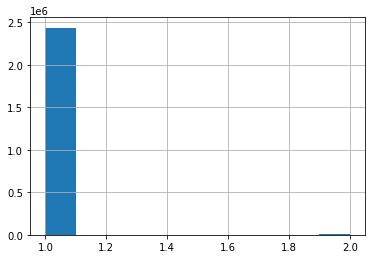

In [87]:
train_df['date_diff'] = (train_df['date'] - train_df['previous_date']).dt.days
train_df['date_diff'].hist()

Seems like we have overwhelmingly conscutive dates.

Let's look at the rows that have a date skipped.

In [90]:
# show rows where date difference is not 1
train_df[train_df['date_diff'] > 1]

,date,store_nbr,family,sales,onpromotion,sales_cumsum,previous_date,date_diff
id,,,,,,,,
637956,2013-12-26,1,AUTOMOTIVE,2.000000,0,7.680000e+02,2013-12-24,2.0
637958,2013-12-26,1,BEAUTY,5.000000,0,6.420000e+02,2013-12-24,2.0
637959,2013-12-26,1,BEVERAGES,1009.000000,0,3.080370e+05,2013-12-24,2.0
637961,2013-12-26,1,BREAD/BAKERY,307.494000,0,9.703200e+04,2013-12-24,2.0
637963,2013-12-26,1,CLEANING,690.000000,0,2.178270e+05,2013-12-24,2.0
...,...,...,...,...,...,...,...,...
2587459,2016-12-26,9,POULTRY,704.269960,0,7.106704e+05,2016-12-24,2.0
2587460,2016-12-26,9,PREPARED FOODS,105.548996,2,1.209120e+05,2016-12-24,2.0
2587461,2016-12-26,9,PRODUCE,2030.049000,3,1.236146e+06,2016-12-24,2.0


Seems like the first day of Christmas is skipped.

In [93]:
assert len(train_df[
    (train_df['date_diff'] > 1) &
    ~(
        (train_df['previous_date'].dt.month == 12) &
        (train_df['previous_date'].dt.day == 24)
    )
]) == 0

# Get rid of data points that contain long stretches of lack of sales

In [ ]:
# how many consecutive empty sales days are needed to throw out a segment.
EMPTY_DAYS = 14

In [ ]:
train_df.groupby(['store_nbr', 'family']).rolling(NUM_DAYS)['sales'].sum()